# KMeans in CUDA w/ Python Demo

### Setup
- "clustering.py" is the file that contains the KMeans wrapper class
- clustering.py makes use of kmeans.so which is build from kmeans.cu and kmeansHelper.cu for CUDA implementation of Kmeans fitting/labeling data
- all files were in the same directory when running prior to submission (i.e. kmeans.cu, kmeansHelper.cu, kmeans.so, iris_nb.ipynb, clustering.py)


In [53]:
# Load modules and import iris dataset
from clustering import KMeans

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans as skKMeans
import time

data = pd.read_csv('iris.csv',header=None)

In [48]:
model = KMeans(k=3, iterations=20, timing=True)
model.fit(data)

initalized kmeans with k =  3 , itr =  20
mxn:  150 x 4
Time to fit model:  0.0032837390899658203


array([[5.00784314, 3.4       , 1.49411765, 0.26078431],
       [6.06      , 2.8175    , 4.6425    , 1.5775    ],
       [7.17368421, 3.12105263, 6.11578947, 2.12105263]])

In [49]:
labels = model.label(data)

Time to label datapoints:  0.0006403923034667969


### Comparison to sklearn's sequential algorithm

In [52]:
model = skKMeans(n_clusters=3, max_iter=20)
start = time.time()
model.fit(data)
end = time.time()
print('Time for sklearn to fit kmeans', end-start)

Time for sklearn to fit kmeans 0.014596223831176758


## Visualization of Results for Verification of Clustering Algorithm

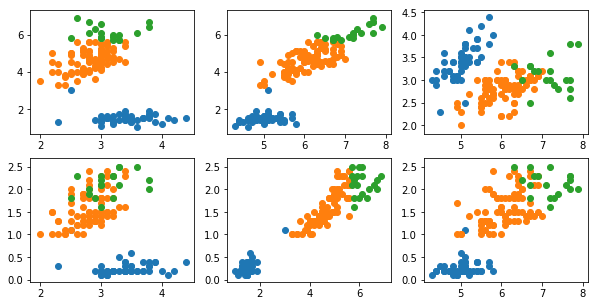

In [51]:
pairs = set([''.join(str(x) for x in sorted((i,j))) for i in range(4) for j in range(4) if i!=j])

f, ax = plt.subplots(2, 3,figsize=(10,5))

for i, pair in enumerate(pairs):
    x = int(pair[0])
    y = int(pair[1])
    pltr = ax[i%2,i%3]
    pltr.scatter(data[labels==0][x],data[labels==0][y])
    pltr.scatter(data[labels==1][x],data[labels==1][y])
    pltr.scatter(data[labels==2][x],data[labels==2][y])